## 4.2 Stochastic Variance Reduced Gradient Descent

### 4.2.1 Problem and stochastic gradient descent

We consider the following finite-sum problem:

$$\min_x \quad \frac{1}{M}\sum_{m=1}^M f_m(x) \hspace{1cm} \mbox{(Finite-Sum Problem)}$$

where $M$ is the size of the dataset, and $f_m(x)$ is the cost function associated with data $m$. This section assumes each $f_m(x)$ is convex and smooth. In real practice, the size of dataset $M$ is very large.

This section discusses how to solve the (Finite-Sum Problem) within a **single** node efficiently. In the next few sections, we will discuss how to solve the problem using mulitple computing nodes.

Since $M$ is large, it is usually very expensive to use the full-batch gradient descent to solve the (Finite-Sum Problem). One widely-used approach is stochastic gradient descent (SGD). At iteration $k$, the node will randomly sample one (or one mini-batch of) data sample(s), compute a stochastic gradient associated with such data, and update the variable along the gradient direction. More concretely, the SGD algorithm has the following recursions:

\begin{align}
& \mbox{Sample one data sample $m_k$ randomly at iteartion $k$ and compute the gradient }\nabla f_{m_k}(x^k)\\
& \mbox{update the variable:}\ x^{k+1} = x^k - \alpha \nabla f_{m_k}(x^k)
\end{align}

To guarantee convergence to the exact global solution, the step-size $\alpha$ has to decay as iterations, which will slow down the convergence of SGD. In the following, we will discuss a variance-reduced stochastic algorithm that can enable convergence to the exact solution with constant step-size. With a constant step-size, SGD will converge to a **nerighborhood** around the global solution.

### 4.2.2 Stochastic variance reduced gradient descent

Stochastic variance-reduced gradient method has many variants: SVRG, SAGA, Finito/MISO, SDCA, etc. In this subsection we discuss the one of the earliest variance-reduced methods: SVRG. SVRG has two loops:

> \begin{align}
& \mbox{For $s = 1,2,\cdots$}\\
& \hspace{5mm} \tilde{x} = \tilde{x}_{s-1} \\
& \hspace{5mm} \tilde{\mu} = \frac{1}{M}\sum_{m=1}^M \nabla f_m(\tilde{x}) \\
& \hspace{5mm} x_0 = \tilde{x} \\
& \hspace{5mm} \mbox{For $k = 1,2,\cdots,K$}\\
& \hspace{15mm}\mbox{Randomly pick $m_k \in \{1,\cdots, n\}$ and update weight as}\\ 
& \hspace{15mm}x^k = x^{k-1} - \alpha\big(\nabla f_{m_k}(x^{k-1}) - \nabla f_{m_k}(\tilde{x}) + \tilde{\mu} \big) \\
& \hspace{5mm} \mbox{Set $\tilde{x}_s = x^K$}
\end{align}

### 4.2.3 Convergence properties

Note that SVRG unilizes a full-batch gradient $\tilde{\mu}$ to help correct the stochastic gradient direction. The stochastic gradient constructed, i.e., 

\begin{align}
\tilde{g} = \nabla f_{m_k}(x^{k-1}) - \nabla f_{m_k}(\tilde{x}) + \tilde{\mu}
\end{align}

in SVRG is unbiased and has diminishing variance. To see the unbiasedness, note that

\begin{align}
\mathbb{E}[\tilde{g}] = \frac{1}{M}\sum_{m=1}^M \nabla f_m(x^{k-1}) - \frac{1}{M}\sum_{m=1}^M \nabla f_m(\tilde{x}) + \tilde{\mu} = \frac{1}{M}\sum_{m=1}^M \nabla f_m(x^{k-1})
\end{align}

To see the diminishing variance, note that

\begin{align}
& \mathbb{E}\|\tilde{g} - \frac{1}{M}\sum_{m=1}^M \nabla f_m(x^{k-1})\|^2 \nonumber \\
=& \mathbb{E}\|\nabla f_{m_k}(x^{k-1}) - \nabla f_{m_k}(\tilde{x}) - \Big( \tilde{\mu} - \frac{1}{M}\sum_{m=1}^M \nabla f_m(x^{k-1}) \Big)\|^2 \nonumber \\
\le& \mathbb{E}\|\nabla f_{m_k}(x^{k-1}) - \nabla f_{m_k}(\tilde{x})\|^2 \le L^2 \mathbb{E}\|x^{k-1} - \tilde{x}\|^2
\end{align}

where the last inequality unilized the $L$-smoothness of each gradient $\nabla f_i(x)$. If $x^{k} \to \tilde{x}$ as $k$ increases, the above relation implies that the gradient noise variance will diminish to zero as $k$ increases. This property guarantees that SVRG can converge to the exact solution with a constant step-size.



### 4.2.4 An example: least-square problem

In this section, we will show a demo on how to solve a least-square problem with SVRG. Suppose one computing node tends to solve the following problem:

$$\min_x \quad \|A x - b\|^2$$

where $\{A, b\}$ are data held locally.

#### 4.2.4.1 Set up Environment

In [1]:
import numpy as np
import torch

#### 4.2.4.2 Generate local data $A$ and $b$

In [2]:
def generate_data(m, n):
    
    A = torch.randn(m, n).to(torch.double)
    x_o = torch.randn(n, 1).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
    
    return A, b

#### 4.2.4.3 One step of SGD

In [3]:
def SGD_one_step(x, A, b, alpha=1e-2):
    m = A.size()[0]
    for _ in range(m):
        # Select a random sample
        i = torch.randint(m,(1,)).item()
        sample = A[i:i+1]
        # Estimate the gradient
        grad_est = sample.t()*(sample.mm(x)-b[i])
        x = x - alpha * grad_est
    return x

#### 4.2.4.4 One step of SVRG

In [4]:
def SVRG_one_step(x, A, b, alpha=1e-2):
    m = A.size()[0]
    x_0 = x.clone()
    grad_0 = A.t().mm(A.mm(x_0) - b)/m # Precompute the full gradient of the step
    for _ in range(m):
        # Select a random sample
        i = torch.randint(m,(1,)).item()
        sample = A[i:i+1]
        # Estimate the gradient
        grad_est_i =  sample.t()*(sample.mm(x)-b[i])
        grad_est_0 =   sample.t()*(sample.mm(x_0)-b[i])
        grad_est = grad_est_i - grad_est_0 + grad_0
        x = x - alpha * grad_est
    return x

With one step of SGD and SVRG defined, we run the SGD and SVRG algorithms to depict the convergence curve of these two optimization methods.

In [5]:
m = 2000
n = 25
max_iter = 50

alpha_SGD = 1e-3
alpha_SVRG = 1e-3

A, b = generate_data(m, n)
# Compute optimal solution
x_opt = torch.inverse(A.t().mm(A)).mm(A.t().mm(b))

x_SGD = torch.zeros(n, 1, dtype=torch.double)     # Initialize x for SGD
x_SVRG = torch.zeros(n, 1, dtype=torch.double)     # Initialize x for SVRG

rel_error_SGD = torch.zeros((max_iter, 1))
rel_error_SVRG = torch.zeros((max_iter, 1))

for ite in range(max_iter):
    if ite%10 == 0:
        print('Progress {}/{}'.format(ite, max_iter))
        
    x_SGD = SGD_one_step(x_SGD, A, b, alpha=alpha_SGD)
    x_SVRG = SVRG_one_step(x_SVRG, A, b, alpha=alpha_SGD)
    
    rel_error_SGD[ite] = torch.norm(x_SGD-x_opt, p=2)/torch.norm(x_opt,p=2)
    rel_error_SVRG[ite] = torch.norm(x_SVRG-x_opt, p=2)/torch.norm(x_opt,p=2)

Progress 0/50
Progress 10/50
Progress 20/50
Progress 30/50
Progress 40/50


Text(0, 0.5, 'Relative error')

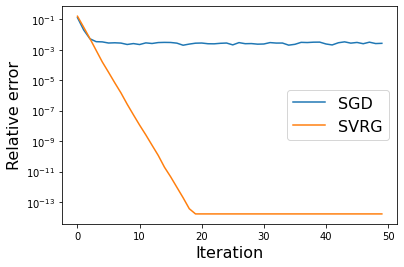

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(rel_error_SGD)
plt.semilogy(rel_error_SVRG)

plt.legend(['SGD', 'SVRG'], fontsize=16)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

It can be observed from the above figure that the SGD can only converge to a neighborhood around the exact solution, while the SVRG can precisely converge to the optimal solution, demonstrating the unbiasness of the SVRG.